<h1> Load the data </h1>


In [65]:
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import numpy as np
import uproot
from hist import Hist, axis
import os

#Constants
current_dir = os.getcwd()
tree_name= "Delphes"  #all of them are named delphes
luminescence = 300 #fb

#Signal
signal_folder = "Signals_DMSimpl_Spin0/"
signal_filename =  "VBF_DM_My0_1000_MXD_10.root"
signal_crossSection = 0.0018 * 1000 #times 1000 to convert from pb to fb
signal_file = uproot.open(signal_folder +signal_filename)

#Background
background_folders = {"BKG_Wjets_WToLNu" : 47744.85 * 1000,
                       "BKG_Zjets_ZToNuNu": 8818.65 * 1000}  #foldername, significance



     #all this is temp for now
#will store data to be used in final "cut chart"
num_cuts = 5
SM_events = [1000,700,200]
NP_events = [500,400,300]
Significance = [1,2.4,5]
   




<h3> Functions </h3>

In [56]:
def calculateWeight(num_events, effective_area, lumi):
    return effective_area * lumi / num_events

<h3> Bins </h3>

In [48]:
binning = {
    "PT": {"range": (20, 300), "bins": 14},  # (300 - 20) / 20 = 14 bins
    "Eta*Eta": {"range": (-25, 25), "bins": 500},  # (25 - (-25)) / 0.1 = 500 bins
    "Delta_Eta": {"range": (0, 10), "bins": 100},  # (10 - 0) / 0.1 = 100 bins
    "Transverse": {"range": (500, 2000), "bins": 75},  # (2000 - 500) / 20 = 75 bins
    "Eta": {"range": (-5, 5), "bins": 100},  # (5 - (-5)) / 0.1 = 100 bins
    "Phi": {"range": (0, 2 * np.pi), "bins": 63}  # (2 * pi - 0) / 0.1 = 63 bins
}





<h1> Plot Everything</h1>

<h3> MET met <h3>

<h3> MET Phi </h3>

sig weight 0.0108
Bkg weight : 368373.1965126148
Bkg weight : 354418.14717672096


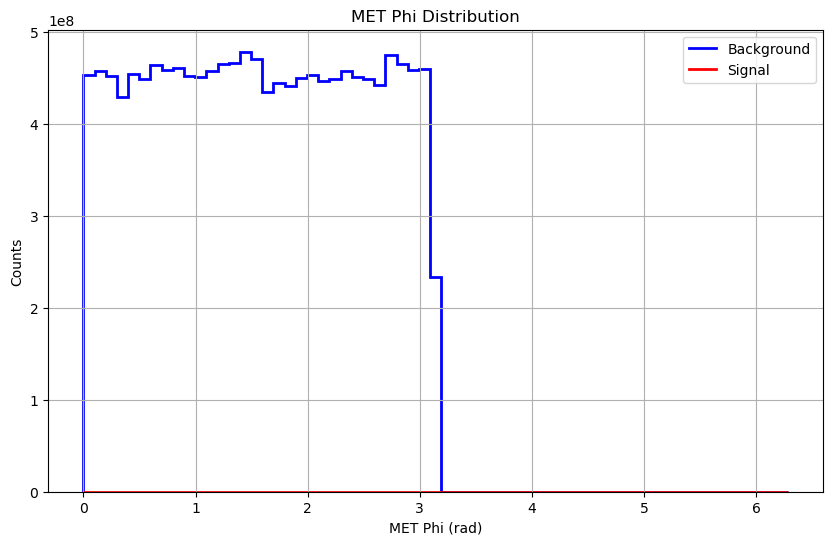

In [66]:
# Create histograms
met_phi_hist_background = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)
met_phi_hist_signal = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)


#Signal Data
signal_tree = signal_file[tree_name]
numSigEvents = len(signal_tree["Event/Event.Weight"].array(library="np"))
signal_weight = calculateWeight(num_events=numSigEvents, effective_area= signal_crossSection, lumi = luminescence)
print("sig weight", signal_weight)

signal_met_phi = signal_tree["MissingET.Phi"].array(library="np")
met_phi_hist_signal.fill(MET_Phi=signal_met_phi,weight = signal_weight)


#Background
for folder_name in os.listdir(current_dir):
    folder_path = os.path.join(current_dir, folder_name)
        
    # Check if the current item is a directory and if its name is in the background_folders dictionary
    if os.path.isdir(folder_path) and folder_name in background_folders:
        cross_section = background_folders[folder_name]
        
        for root_file in os.listdir(folder_path):
            if root_file.endswith(".root"):
                file_path = os.path.join(folder_path, root_file)
                background_file = uproot.open(file_path)
                background_tree = background_file[tree_name]

                numBkgEvents= len(background_tree["Event/Event.Weight"].array(library="np"))
                calculatedWeight = calculateWeight(num_events=numBkgEvents, effective_area= cross_section, lumi = luminescence)
                print("Bkg weight :" , calculatedWeight)
                

                background_met_phi = background_tree["MissingET.Phi"].array(library="np")
                met_phi_hist_background.fill(MET_Phi=background_met_phi,weight =calculatedWeight)
                



#Set up histogram
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    met_phi_hist_background.values(),
    met_phi_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    met_phi_hist_signal.values(),
    met_phi_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=2
)

# Add labels and legend
plt.xlabel('MET Phi (rad)')
plt.ylabel('Counts')
plt.title('MET Phi Distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<h2> Jets </h2>

In [54]:
#For code reusability

def PlotJets(binname,dataname):
    j0_hist_background = Hist(
            axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
        )
    j0_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
    )

    #J1
    j1_hist_background = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )
    j1_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )


    # Signal processing
    signal_jets = signal_tree["Jet."+dataname].array(library="np")
    signal_filtered_jets = [entry for entry in signal_jets if len(entry) >= 2]  # At least two entries
    signal_j0 = np.array([entry[0] for entry in signal_filtered_jets])
    signal_j1 = np.array([entry[1] for entry in signal_filtered_jets])

    # Ensure weights match the number of entries in filtered data
    valid_indices = [i for i, entry in enumerate(signal_jets) if len(entry) >= 2]
    signal_weights_filtered = np.array([signal_weights[i] for i in valid_indices])
    normalized_signal_weights_filtered = signal_weights_filtered / np.mean(signal_weights_filtered)

    j0_hist_signal.fill(thedata=signal_j0, weight=normalized_signal_weights_filtered[:len(signal_j0)])
    j1_hist_signal.fill(thedata=signal_j1, weight=normalized_signal_weights_filtered[:len(signal_j1)])

    # Background processing
    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)
        
        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:
            cross_section = background_folders[folder_name]
            
            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_file = uproot.open(file_path)
                    background_tree = background_file[tree_name]

                    # Extract and normalize weights
                    background_weights = background_tree["Event/Event.Weight"].array(library="np")
                    
                    # Extract and filter jet PT
                    background_jets = background_tree["Jet." + dataname].array(library="np")
                    background_filtered_jets = [entry for entry in background_jets if len(entry) >= 2]  # At least two entries
                    
                    # Extract J0 and J1
                    background_j0 = np.array([entry[0] for entry in background_filtered_jets])
                    background_j1 = np.array([entry[1] for entry in background_filtered_jets])

                    # Ensure weights match the entries in filtered data
                    valid_indices = [i for i, entry in enumerate(background_jets) if len(entry) >= 2]
                    filtered_weights = np.array([background_weights[i] for i in valid_indices])
                    normalized_bkg_filtered_weights = filtered_weights / np.mean(filtered_weights)

                    # Make sure filtered weights are aligned with filtered data
                    if len(background_j0) <= len(normalized_bkg_filtered_weights):
                        j0_hist_background.fill(thedata=background_j0, weight=normalized_bkg_filtered_weights[:len(background_j0)])
                        j1_hist_background.fill(thedata=background_j1, weight=normalized_bkg_filtered_weights[:len(background_j1)])
    

        

    # Create a figure and a set of subplots (2 columns, 1 row)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot J0
    axs[0].stairs(
        j0_hist_background.values(),
        j0_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[0].stairs(
        j0_hist_signal.values(),
        j0_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=2
    )
    axs[0].set_xlabel(dataname+'(j0)')
    axs[0].set_ylabel('Counts')
    axs[0].set_title(dataname+'(j0) Distributions')
    axs[0].legend()
    axs[0].grid(True)

    # Plot J1
    axs[1].stairs(
        j1_hist_background.values(),
        j1_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[1].stairs(
        j1_hist_signal.values(),
        j1_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=2
    )
    axs[1].set_xlabel(dataname+'(j1)')
    axs[1].set_ylabel('Counts')
    axs[1].set_title(dataname+'(j1) Distributions')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


<h3> PT(j0) , PT(j1) </h3>

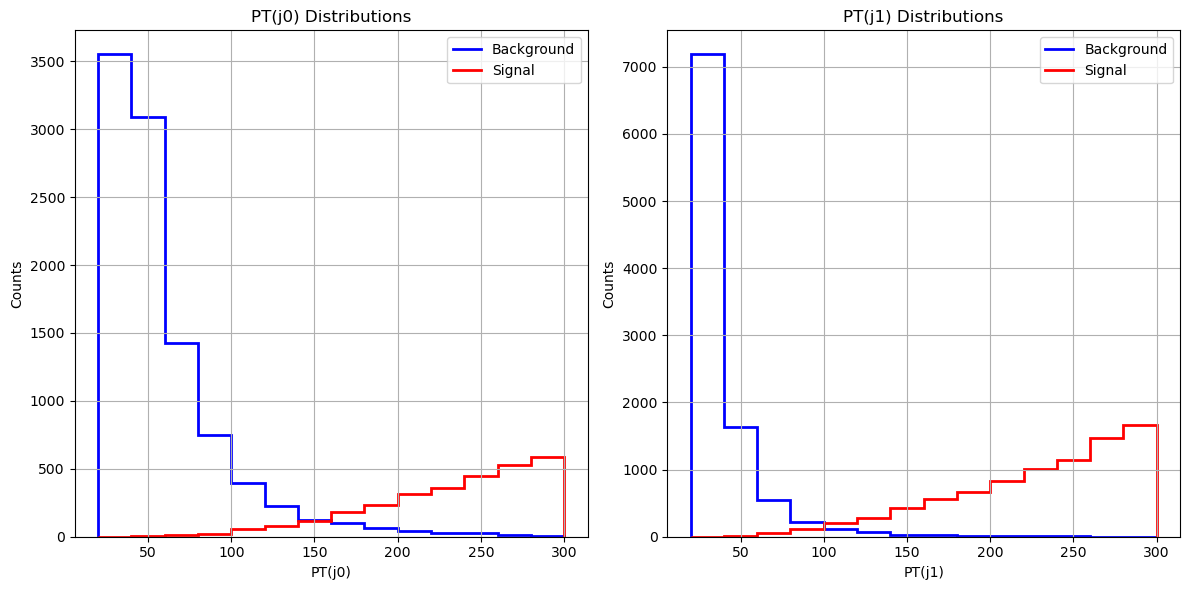

In [55]:
PlotJets("PT","PT")

<h3>Phi(J0,J1)</h3>

In [ ]:
PlotJets("Phi","Phi")

<h3> Eta j0. j1 </h3>

In [ ]:
PlotJets("Eta","Eta")

<h1> Step 3: Iteratively Plot, then Cut <h1>

In [ ]:
#Testing stuff

#this is how I might make a cut
trial = signalevents['Jet'][signalevents.Jet.PT > 30].compute()['PT']
trial


<b> $\eta$($j_0$) *  $\eta$($j_1$) </b>

<b> abs($\Delta$($j_0$,$j_1$)) </b>

<b>Pt($j_0$) </b>

<b>Pt($j_1$)</b>

<b> $M_{ET}$, <b>

<h1>Step 5: Compile full Cut Chart </h1>

In [ ]:

column_width = 12  

# Create the grid header
header_row = f"{'Cut #':^{column_width}} | {'SM Events':^{column_width}} | {'NP Events':^{column_width}} | {'Significance':^{column_width}}"
print(header_row)

# Print a separator line
print("-" * (len(header_row) + 1))

#Initial Conditions
init_data = f"{'    Init':{column_width}} | {SM_events[0]:^{column_width}} | {NP_events[0]:^{column_width}} | {Significance[0]:^{column_width}.2f}"  # 
print(init_data)

# Iterate through data and format each row
for i in range(1, num_cuts):  # Use range(1, num_cuts+1) for 1 to num_cuts (inclusive)
    row_data = f"{i:{column_width}} | {SM_events[i]:^{column_width}} | {NP_events[i]:^{column_width}} | {Significance[i]:^{column_width}.2f}" 
    print(row_data)


